<a href="https://colab.research.google.com/github/kirubarajan/roft/blob/master/annotation/analysis/research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Loading and Cleaning

In [1]:
!pip install fsspec gcsfs
!pip install --upgrade matplotlib

In [2]:
import json
import collections
import random
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy import stats
sns.set_theme(style="whitegrid")
sns.set_palette(sns.color_palette("Set2"))

DATABASE_DUMP_FILE = 'gs://roft_buckups/10-25-21.json'

In [3]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [4]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [5]:
with tf.io.gfile.GFile(DATABASE_DUMP_FILE, 'r') as f:
    lines = f.readlines()
    db = json.loads(lines[1])

def get_df(sql_model='core.annotation'):
    df = pd.DataFrame(db)
    df = df[df.model == sql_model]
    
    if 'date' in df.columns.values:
        df = df.set_index('date')

    return pd.json_normalize(df.fields).assign(pk=df.pk.values)

In [6]:
df = pd.DataFrame(db)
print(set(df["model"].tolist()))

{'core.prompt', 'auth.user', 'core.dataset', 'core.feedbackoption', 'admin.logentry', 'core.playlist', 'core.system', 'core.generation', 'core.annotation', 'core.timestamp', 'core.profile', 'core.decodingstrategy', 'contenttypes.contenttype', 'sessions.session', 'auth.permission'}


### Load all the tables

In [7]:
annotation_df = get_df()
profile_df = get_df('core.profile')
generation_df = get_df('core.generation')
prompt_df = get_df('core.prompt')
playlist_df = get_df('core.playlist')
decodingstrategy_df = get_df('core.decodingstrategy')
user_df = get_df('auth.user')

### Modify column names to avoid duplicates across tables.

In [8]:
prompt_df = prompt_df.rename(columns={"body": "prompt_body"})
generation_df = generation_df.rename(columns={"body": "gen_body"})
decodingstrategy_df = decodingstrategy_df.rename(
    columns={"name": "dec_strat", "value": "dec_strat_value"})
annotation_df["date"] = pd.to_datetime(annotation_df["date"])

### Merge all the relevant tables together.

In [9]:
gen_to_playlist = {}
for idx, row in playlist_df.iterrows():
  shortname = row["shortname"]
  version = row["version"]
  generations = row["generations"]
  for gen_id in generations:
    gen_to_playlist[gen_id] = (shortname, version)

In [10]:
full_df = annotation_df.join(generation_df.set_index('pk'), on='generation')
full_df = full_df.join(prompt_df.set_index('pk'), 'prompt')
full_df = full_df.join(decodingstrategy_df.set_index('pk'), 'decoding_strategy')
full_df = full_df.join(user_df.set_index('pk'), 'annotator')

In [11]:
playlist_names = [] 
playlist_versions = []
for idx, row in full_df.iterrows():
  gen_id = row["generation"]
  playlist_info = gen_to_playlist[gen_id]
  playlist_names.append(playlist_info[0])
  playlist_versions.append(playlist_info[1])
full_df["playlist_name"] = playlist_names
full_df["playlist_version"] = playlist_versions

### Filter out annotations not part of Version 2

In [12]:
full_df = full_df[full_df.apply(lambda row: row["playlist_version"]=="0.2", axis=1)]

In [13]:
original_df = full_df

## Filter out unacceptable users
Methods for filtering out annotations for users who have NOT agreed to have their data analyzed (and filtering out us).

**TO HAVE YOUR PROFILE FILTERED OUT, PLEASE FILL OUT THE GOOGLE FORM AND SPECIFY "NO" TO THE QUESTION ABOUT WHETHER YOU WANT TO PARTICIPATE IN RESEARCH.**

In [14]:
SURVEY_SPREADSHEET_ID = '1j9-nqsGFhpKSas_z1-IRKORlVbmjTzJ4_u_q6u-hOvg'
KEY = "ageed_to_research"
worksheet = gc.open_by_key(SURVEY_SPREADSHEET_ID).sheet1
rows = worksheet.get_all_values()

survey_df = pd.DataFrame.from_records(rows[1:], columns=rows[0])

survey_filter_df = survey_df[survey_df[KEY] == 'Yes']

# all the users who GAVE US PERMISSION
users_filter_df = user_df[user_df.username.isin(survey_filter_df["username"].values)]

# Filter all of the data frames that we use for analysis.
full_df = full_df[full_df.annotator.isin(users_filter_df.pk)]
annotation_df = annotation_df[annotation_df.annotator.isin(users_filter_df.pk)]

##Filter out annotators we don't like.
ID 4334 used exploits and other scripts to manipulate the site.
The others had over 90% of annotations on the same boundary index.

In [15]:
full_df = full_df[~full_df['annotator'].isin([4415, 5349, 4644, 4334])]

## Filter out the extra all-human examples from Recipes

In [16]:
recipe_frequencies = collections.Counter(full_df[full_df["playlist_name"]=="Recipes"]["num_sentences"])
print(recipe_frequencies)
avg_freq_non_final = int(np.round(np.mean([recipe_frequencies[i] for i in range(10)])))

random.seed(2342)
def filter_fn(row):
  if (row["playlist_name"] == "Recipes") and (row["num_sentences"] == 10):
    return random.random() < (avg_freq_non_final / recipe_frequencies[10])
  else:
    return True
full_df = full_df[full_df.apply(filter_fn, axis=1)]

Counter({10: 2823, 1: 1131, 3: 1118, 6: 1023, 2: 1011, 4: 1010, 5: 989, 7: 700, 8: 657, 9: 653})


In [17]:
recipe_frequencies = collections.Counter(full_df[full_df["playlist_name"]=="Recipes"]["num_sentences"])
recipe_frequencies

Counter({1: 1131,
         2: 1011,
         3: 1118,
         4: 1010,
         5: 989,
         6: 1023,
         7: 700,
         8: 657,
         9: 653,
         10: 811})

##Add survey results to the DataFrame

In [18]:
full_df = full_df.join(survey_df.set_index('username'), 'username')

##Process survey responses
Map the familiarity questions to a 1-5 labeling scheme and process the "major" column to a list of major codes.

In [19]:
def remap_familiarity_labels(x):
  if x == "I've never heard of them.":
    return 1
  elif x == "I've read about them in the news or a blog post.":
    return 2
  elif x == "I’ve been excitedly following them.":
    return 3
  elif x == "I’ve used them before (either with the OpenAI API, HuggingFace Transformers, etc.).":
    return 4
  else:
    return -1

def remap_genre_fam_labels(x):
  if x == "Never":
    return 1
  elif x == "Once to a few times per year":
    return 2
  elif x == "Once to a few times per month":
    return 3
  elif x == "Once to a few times per week":
    return 4
  elif x == "Daily":
    return 5
  else:
    return -1

full_df = full_df.rename(columns={"What did you (or what are you planning to) major/minor in?": "major", 
                                              "How often do you consult a recipe when preparing food?": "recipe_familiarity", 
                                              'How often do you read news from credible news publishers (Philadelphia Inquirer, Wall Street Journal, New York Times, etc.)?':'news_familiarity', 
                                              'How often do you read fiction on the internet (fan fiction, creative writing sub-reddits, ebooks, etc.)?':'stories_familiarity',
                                              'familiarity':'gen_familiarity',
                                              'Did you read the RoFT Guide before you tried the game?': 'read_guide'})

full_df['recipe_familiarity'] = full_df['recipe_familiarity'].apply(remap_genre_fam_labels)
full_df['news_familiarity'] = full_df['news_familiarity'].apply(remap_genre_fam_labels)
full_df['stories_familiarity'] = full_df['stories_familiarity'].apply(remap_genre_fam_labels)
full_df['gen_familiarity'] = full_df['gen_familiarity'].apply(remap_familiarity_labels)

## Process Majors
Parse the free text responses into one of 34 different major codes

In [20]:
#@title Majors
def process_major(x):
  major_labels = []
  CIS = ['Computer and Information Science', 'CIS', 'Computer Science', 'Computer science', 'CS', 'Comp sci', 'computer science', 'cis', 'CSCI']
  MCIT = ['MICT', 'MCIT', 'Computer and Information Technology', 'Information Technology', 'Computer & Information Technology', 'Computer and information tech', 'mcit', 'OMCIT', 'Computer and Information Tech', 'Computer Information and Technology', 'Computer Information Technology', 'Computer and Info Tech', 'CIT', 'computer information technology', 'Computer Science and information Technology', 'cit']
  FIN = ['Finance', 'finance', 'Business Analytics']
  ACCT = ['accounting', 'Accounting']
  BA = ['Business Administration']
  QM = ['quantitative methods']
  CMPE = ['Computer Engineering']
  PHYS = ['Physics', 'physics']
  COM = ['Communications', 'communications']
  COG = ['cognitive science', 'Cognitive Science']
  CBIO = ['Computational Biology']
  ROBO = ['ROBO', 'Robotics']
  LING = ['Linguistics', 'LING']
  EE = ['Environmental Engineering']
  ESE = ['ESE', 'electrical engineering', 'EE']
  NETS = ['NETS', 'Networked and Social Systems Engineering', 'Systems Engineering']
  DATS = ['Data Science', 'data science', 'DATS']
  BIO = ['Biology', 'biology']
  ARTH = ['Art History']
  HIST = ['History', 'history', 'HIST']
  PHIL = ['Philosophy']
  ENT = ['Entrepreneurship']
  DMD = ['DMD', 'Digital Media Design']
  MATH = ['MATH', 'math', 'mathematics', 'Mathematics']
  MED = ['medicine']
  NEURO = ['neuroscience', 'Neuroscience']
  BE = ['BE', 'bioengineering', 'Bioengineering']
  CBE = ['Chemical Engineering']
  CIV = ['civil engineering', 'Civil Engineer']
  MEAM = ['MEAM', 'mechanical engineering', 'Mechanical Engineering']
  ECON = ['Economics', 'ECON']
  CGGT = ['CGGT', 'Computer Graphics and Game Technology']
  SCMP = ['Scientific Computing']

  if any(substring in x for substring in CIS):
    major_labels.append("CIS")
  if any(substring in x for substring in MCIT):
    major_labels.append("MCIT")
  if any(substring in x for substring in FIN):
    major_labels.append("FIN")
  if any(substring in x for substring in ACCT):
    major_labels.append("ACCT")
  if any(substring in x for substring in BA):
    major_labels.append("BA")
  if any(substring in x for substring in QM):
    major_labels.append("QM")
  if any(substring in x for substring in PHYS):
    major_labels.append("PHYS")
  if any(substring in x for substring in COM):
    major_labels.append("COM")
  if any(substring in x for substring in COG):
    major_labels.append("COG")
  if any(substring in x for substring in CBIO):
    major_labels.append("CBIO")
  if any(substring in x for substring in ROBO):
    major_labels.append("ROBO")
  if any(substring in x for substring in LING):
    major_labels.append("LING")
  if any(substring in x for substring in EE):
    major_labels.append("EE")
  if any(substring in x for substring in ESE):
    major_labels.append("ESE")
  if any(substring in x for substring in NETS):
    major_labels.append("NETS")
  if any(substring in x for substring in DATS):
    major_labels.append("DATS")
  if any(substring in x for substring in BIO):
    major_labels.append("BIO")
  if any(substring in x for substring in ARTH):
    major_labels.append("ARTH")
  if any(substring in x for substring in HIST):
    major_labels.append("HIST")
  if any(substring in x for substring in PHIL):
    major_labels.append("PHIL")
  if any(substring in x for substring in ENT):
    major_labels.append("ENT")
  if any(substring in x for substring in DMD):
    major_labels.append("DMD")
  if any(substring in x for substring in MATH):
    major_labels.append("MATH")
  if any(substring in x for substring in MED):
    major_labels.append("MED")
  if any(substring in x for substring in NEURO):
    major_labels.append("NEURO")
  if any(substring in x for substring in BE):
    major_labels.append("BE")
  if any(substring in x for substring in CIV):
    major_labels.append("CIV")
  if any(substring in x for substring in MEAM):
    major_labels.append("MEAM")
  if any(substring in x for substring in ECON):
    major_labels.append("ECON")
  if any(substring in x for substring in CGGT):
    major_labels.append("CGGT")
  if any(substring in x for substring in CMPE):
    major_labels.append("CMPE")
  if any(substring in x for substring in CBE):
    major_labels.append("CBE")
  if any(substring in x for substring in SCMP):
    major_labels.append("SCMP")

  if x == 'Engineering':
    major_labels.append("ENG")
  if x == 'Computer':
    major_labels.append("MCIT")
  if x == 'AI':
    major_labels.append("AI")
  if x == 'urban planning':
    major_labels.append('URB')
  if x == 'Stories':
    major_labels.append('STOR')

  return major_labels

full_df['major'] = full_df['major'].apply(process_major)

## Cleaning up 
Rename columns and delete unused columns

In [21]:
## TODO: Figure out what the "decoding_strategy" and "dataset" fields actually do -- do they indicate the source generations file? If so, might be able to use to recover CTRL splits

columns_to_drop = ['attention_check', 'dec_strat', 'password', 'last_login', 'is_superuser', 'is_staff', 'first_name', 'last_name', 'email', 'is_active', 'groups', 'user_permissions', 'playlist_version', 'ageed_to_research', 'dataset', 'decoding_strategy']
full_df = full_df.drop(columns_to_drop, axis=1)

full_df = full_df.rename(columns={'system':'model','playlist_name':'dataset', 'boundary':'predicted_boundary_index', 'num_sentences':'true_boundary_index'})
full_df['true_boundary_index'] = full_df['true_boundary_index'] - 1

## Recover CTRL Labels
In our original analysis we lost the distinction between when a speech was generated with control code and without a control code. This bit of code recovers that information.

In [22]:
CTRL_GEN_FILES_NOCODE = ['gs://roft_datasets/generations_v3/speeches/generations-ctrl-nocode-speeches-dev.json', 
                                                         'gs://roft_datasets/generations_v3/speeches/generations-ctrl-nocode-speeches-train.json', 
                                                         'gs://roft_datasets/generations_v3/speeches/generations-ctrl-nocode-speeches-test.json']
CTRL_GEN_FILES_CODE = ['gs://roft_datasets/generations_v3/speeches/generations-ctrl-Politics-speeches-dev.json', 
                                                   'gs://roft_datasets/generations_v3/speeches/generations-ctrl-Politics-speeches-train.json', 
                                                   'gs://roft_datasets/generations_v3/speeches/generations-ctrl-Politics-speeches-test.json']

reverse_lookup_dict = dict()
for fname in CTRL_GEN_FILES_CODE:
  with tf.io.gfile.GFile(fname, 'r') as f:
    gen_data = json.load(f)
    for gen in gen_data['generations']:
      # Insert the first generated sentence into the dictionary as key. 
      # Value is a boolean. True = generation was made w/ Politics control code
      # Reasoning for try block is in the case of all-human examples
      try: reverse_lookup_dict[gen['generation'][0]] = True
      except IndexError: pass

for fname in CTRL_GEN_FILES_NOCODE:
  with tf.io.gfile.GFile(fname, 'r') as f:
    gen_data = json.load(f)
    for gen in gen_data['generations']:
      # Insert the first generated sentence into the dictionary as key. 
      # Value is a boolean. True = generation was made w/ Politics control code
      try: reverse_lookup_dict[gen['generation'][0]] = False
      except IndexError: pass

print(reverse_lookup_dict)

{'This is a great opportunity for me as your Vice President.': True, 'The Almighty has given us a country for our use as long as we shall live in it': True, 'I have just returned from a trip that took me around the world.   ': True, 'In these two nations we are privileged to meet with representatives who represent some 30 million people -- one third of our total population.': True, 'In this new situation we are placed between two hostile powers.': False, 'But today there are two things which make this occasion particularly solemn.': True, 'The acts of Congress relating thereto, however, have been, from time to time, renewed with varying modifications in each of these States.   ': True, 'We have seen how difficult it can be to recover from natural disasters.': True, 'He began his speech with these words:   "Mr. Speaker: At this time, it is more important than ever before to make sure we are working together toward an American foreign policy which will bring peace and prosperity to all p

In [23]:
# Use the reverse lookup dict to reassign labels for the CTRL generations
# (If all human then randomly assign to either)
def reassign_ctrl_label(x):
  new_model_label = x['model']
  if x['model'] == 'ctrl':
    if x['gen_body']:
      if reverse_lookup_dict[x['gen_body'].split('_SEP_')[0]]:
        new_model_label = 'ctrl-Politics'
      else:
        new_model_label = 'ctrl-nocode'
    else:
      if random.random() > 0.5:
        new_model_label = 'ctrl-Politics'
      else:
        new_model_label = 'ctrl-nocode'
  return new_model_label

random.seed(42)
full_df['model'] = full_df.apply(reassign_ctrl_label, axis=1)

##Reorder Columns
Re-order columns so that they make sense and are easier to read

In [24]:
column_order = ['date', 'username', 'dataset', 'model', 'dec_strat_value', 'prompt', 'prompt_body', 'generation', 'gen_body','true_boundary_index', 'predicted_boundary_index', 'points', 'major', 'english', 'read_guide', 'recipe_familiarity', 'news_familiarity', 'stories_familiarity', 'gen_familiarity', 'prompt_index', 'annotator', 'date_joined', 'Timestamp', 'Email Address']
full_df[column_order]

,date,username,dataset,model,dec_strat_value,prompt,prompt_body,generation,gen_body,true_boundary_index,predicted_boundary_index,points,major,english,read_guide,recipe_familiarity,news_familiarity,stories_familiarity,gen_familiarity,prompt_index,annotator,date_joined,Timestamp,Email Address
112,2021-08-31 17:11:39.095000+00:00,mcolombo,Recipes,finetuned,0.4,13803,HOW TO MAKE: Baby Shell Pasta Salad With Kalam...,22877,"Meanwhile, combine all dressing ingredients in...",2,0,0,[NETS],Yes,,2,3,5,2,2130,1666,2021-08-31T17:10:18.716Z,9/6/2021 18:14:26,mcolombo@seas.upenn.edu
138,2021-09-02 02:27:39.754000+00:00,Hongyu Zhang,Recipes,finetuned,0.4,20538,HOW TO MAKE: Black Sesame Seed Bagels\nIngredi...,26262,Brush with malt syrup or sugar._SEP_Bake for 1...,7,3,0,[CIS],No,,4,4,4,2,7824,1699,2021-09-02T02:26:11.170Z,9/6/2021 13:53:15,hz53@seas.upenn.edu
172,2021-09-02 13:41:57.862000+00:00,Xuanyang,Short Stories,gpt2,0.4,1810,Don't worry about credit- if anything always j...,1785,It was probably because they were really old e...,7,1,0,[ROBO],No,,2,2,4,4,2739,1720,2021-09-02T13:36:57.794Z,9/3/2021 21:55:38,wxy@seas.upenn.edu
179,2021-09-02 13:44:42.769000+00:00,zszeke,Recipes,finetuned,0.4,20654,HOW TO MAKE: Simply Elegant Green Beans\nIngre...,26379,Just increase the amount of walnuts to 2/3 cup...,8,1,0,[ESE],Yes,,4,1,4,1,8030,1727,2021-09-02T13:42:23.614Z,9/4/2021 16:38:17,zszeke@seas.upenn.edu
181,2021-09-02 13:45:17.775000+00:00,Xuanyang,Recipes,gpt2-xl,0.4,14332,HOW TO MAKE: Angela's Awesome Enchiladas\nIngr...,19285,"When the mixture has cooled slightly, fold it ...",5,5,5,[ROBO],No,,2,2,4,4,5973,1720,2021-09-02T13:36:57.794Z,9/3/2021 21:55:38,wxy@seas.upenn.edu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46967,2021-10-18 04:36:37.095000+00:00,sweetMelon,Recipes,gpt2-xl,0.4,15533,HOW TO MAKE: Khubani Ka Meetha (Apricot Deligh...,20486,Transfer to a bowl and let cool down completel...,3,9,0,[MCIT],No,Yes,2,4,4,3,3641,4433,2021-10-07T12:25:48.534Z,10/16/2021 4:37:46,jiayuzhu@seas.upenn.edu
46968,2021-10-18 04:36:47.625000+00:00,sweetMelon,Recipes,finetuned,0.4,20608,HOW TO MAKE: Baked Salmon Fillets Dijon\nIngre...,26332,The one serving is 12 ounces per person!_SEP_G...,7,9,3,[MCIT],No,Yes,2,4,4,3,7943,4433,2021-10-07T12:25:48.534Z,10/16/2021 4:37:46,jiayuzhu@seas.upenn.edu
46969,2021-10-18 04:37:01.490000+00:00,sweetMelon,Recipes,finetuned,0.4,13785,HOW TO MAKE: Delicious Greek Garlic Chicken\nI...,22806,Pour the boiling water over the chicken pieces...,2,7,0,[MCIT],No,Yes,2,4,4,3,2017,4433,2021-10-07T12:25:48.534Z,10/16/2021 4:37:46,jiayuzhu@seas.upenn.edu
46970,2021-10-18 04:37:12.887000+00:00,sweetMelon,Recipes,finetuned,0.4,19077,HOW TO MAKE: Cheddar-Polenta Biscuits with Ham...,24651,Transfer the biscuits to the prepared baking s...,4,9,0,[MCIT],No,Yes,2,4,4,3,4999,4433,2021-10-07T12:25:48.534Z,10/16/2021 4:37:46,jiayuzhu@seas.upenn.edu


## Replace all human examples with 'human' model

So that the all human examples do not interfere with our analysis



In [25]:
def reassign_all_human_model(x):
  if x['gen_body']:
    return x['model']
  else:
    return 'human'

full_df['model'] = full_df.apply(reassign_all_human_model, axis=1)

# Helper Functions

In [26]:
def map_playlist_name(playlist):
  """Converts playlist names to the ones we want to use in the paper."""
  if playlist == 'New York Times':
    return "News"
  elif playlist == 'Presidential Speeches':
    return "Speeches"
  elif playlist == 'Recipes':
    return "Recipes"
  elif playlist == 'Short Stories':
    return "Stories"

def map_p_value(x):
  "Converts float p values to the naames we want to use in the paper."""
  if x >= 0:
    return "$p={}$".format(x)
  else:
    return "random"

def save(filename):
  plt.tight_layout()
  plt.savefig(filename)
  plt.show()

# Dataset Statistics

## Counts

In [27]:
full_df.groupby('dataset').count()

,date,annotator,generation,playlist,predicted_boundary_index,points,reason,pk,model,prompt,gen_body,prompt_body,true_boundary_index,prompt_index,dec_strat_value,username,date_joined,Timestamp,Email Address,major,english,recipe_familiarity,news_familiarity,stories_familiarity,gen_familiarity,read_guide
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,
New York Times,4951,4951,4951,4951,4951,4951,4951,4951,4951,4951,4951,4951,4951,4951,4951,4951,4951,4951,4951,4951,4951,4951,4951,4951,4951,4951
Presidential Speeches,5135,5135,5135,5135,5135,5135,5135,5135,5135,5135,5135,5135,5135,5135,5135,5135,5135,5135,5135,5135,5135,5135,5135,5135,5135,5135
Recipes,9103,9103,9103,9103,9103,9103,9103,9103,9103,9103,9103,9103,9103,9103,9103,9103,9103,9103,9103,9103,9103,9103,9103,9103,9103,9103
Short Stories,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999,4999


In [28]:
original_df.groupby('playlist_name').count()

,date,annotator,generation,playlist,boundary,points,attention_check,reason,pk,system,prompt,decoding_strategy,gen_body,prompt_body,num_sentences,dataset,prompt_index,dec_strat,dec_strat_value,password,last_login,is_superuser,username,first_name,last_name,email,is_staff,is_active,date_joined,groups,user_permissions,playlist_version
playlist_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
New York Times,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806,7806
Presidential Speeches,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374,8374
Recipes,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978,17978
Short Stories,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007,8007


## Decoding Strategies

In [29]:
df = full_df.groupby(['dataset', 'dec_strat_value']).count()
df = df.reset_index()

In [30]:
values = [-1, 0.0, 0.4, 1.0]

def get_dec_strat_counts(dataset):
  df2 = df[df["dataset"]==dataset].filter(items=["dataset", "dec_strat_value", "pk"])
  counts = [df2[df2["dec_strat_value"]==v]["pk"].tolist() for v in values]
  counts = [c[0] if c else 0 for c in counts]
  return counts

nytimes_counts = get_dec_strat_counts("New York Times")


In [31]:
df2 = df.filter(items=["dataset", "dec_strat_value", "pk"])
df2 = df2.groupby(['dataset', 'dec_strat_value']).sum().unstack()
df2 = df2.fillna(0)
df2.columns = [str(a[-1]) for a in df2.columns.to_flat_index()]

sums = df2.sum(axis=1)
df2["-1.0"] = df2["-1.0"] / sums
df2["0.0"] = df2["0.0"] / sums
df2["0.4"] = df2["0.4"] / sums
df2["1.0"] = df2["1.0"] / sums

df2 = df2.reset_index()
df2

,dataset,-1.0,0.0,0.4,1.0
0,New York Times,0.043426,0.330640,0.305191,0.320743
1,Presidential Speeches,0.000000,0.000000,1.000000,0.000000
2,Recipes,0.000000,0.000000,1.000000,0.000000
3,Short Stories,0.000000,0.109622,0.783957,0.106421


Short Stories


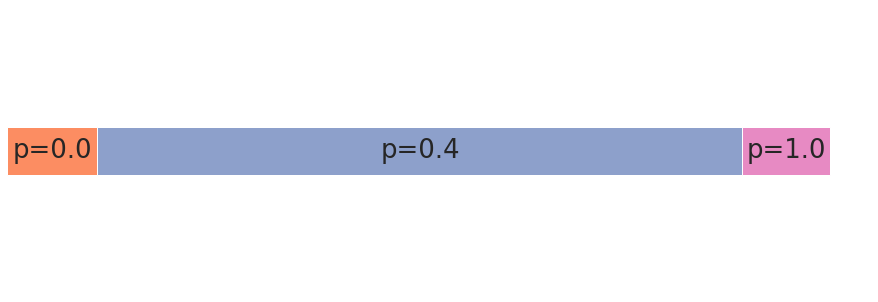

Recipes


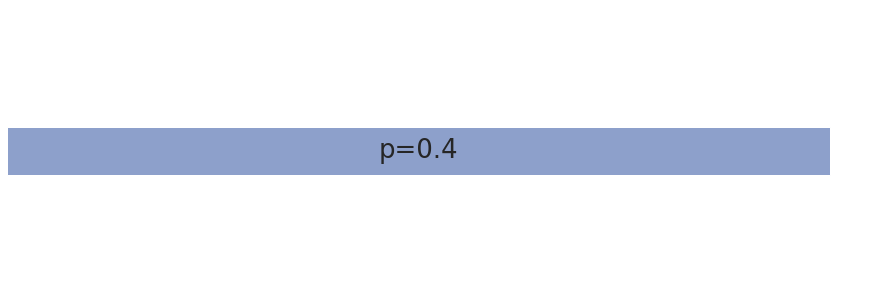

New York Times


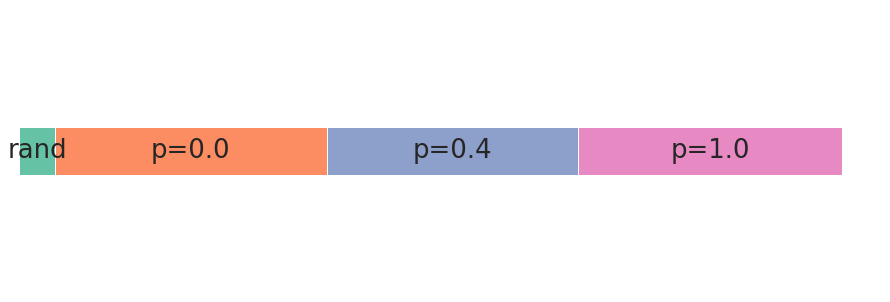

Presidential Speeches


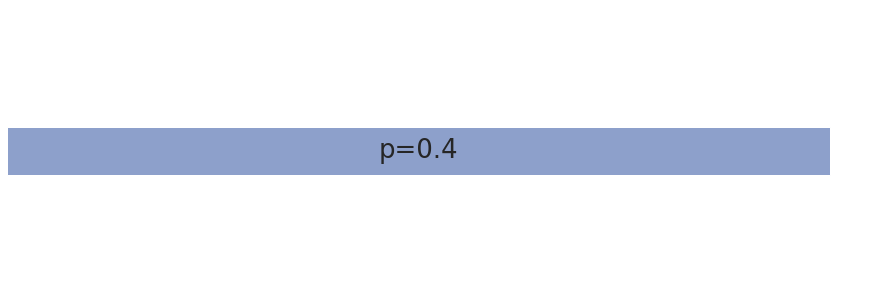

<AxesSubplot:>

In [32]:
import matplotlib

def decide_label(i):
  v = float(values[i])
  if v >= 0:
    return "p={}".format(v)
  else:
    return "rand"

def plot(dataset):
  print(dataset)
  ax = plt.figure(figsize=[12, 4]).subplots(1, 1)

  df3 = df2[df2["dataset"]==dataset]
  ax = df3.plot(kind='barh', stacked=True, width=0.1, ax=ax)

  for i, c in enumerate(ax.containers):
    labels = [decide_label(i) if v.get_width() > 0.0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='center', fontsize=26)
  ax.get_legend().remove()
  plt.grid(False)
  plt.axis('off')
  plt.tight_layout()
  ax.set_position((0, 0, 1, 1))
  ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
  ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator())

  plt.savefig("decoding_dist_{}.pdf".format(dataset.lower().replace(" ", "_")), transparent=True)
  plt.show()
  return ax

plot("Short Stories")
plot("Recipes")
plot("New York Times")
plot("Presidential Speeches")

In [33]:
values

[-1, 0.0, 0.4, 1.0]

# Analysis

## Mean points

In [34]:
def analyze_per_playlist():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  model_names = set(full_df["model"].tolist())
  for playlist in playlist_names:
    for model in model_names:
      df = full_df[(full_df["dataset"]==playlist) & 
                          (full_df["model"]==model)]
      
      if len(df) > 0:
        info = {"playlist": playlist,
                "model": model,
                "mean score": np.mean(df["points"]),
                "median score": np.median(df["points"]),
                "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
                "num_annotations": len(df)
        }
        info_to_return.append(info)
  return pd.DataFrame(info_to_return)

analyze_per_playlist()

,playlist,model,mean score,median score,fraction_nonzero,num_annotations
0,Short Stories,gpt2-xl,1.905201,1.0,0.566820,1519
1,Short Stories,gpt2,2.238628,2.0,0.575559,2594
2,Short Stories,davinci,1.764706,1.0,0.617647,68
3,Short Stories,human,2.047677,0.0,0.411980,818
4,Recipes,gpt2-xl,1.770853,0.0,0.492034,2134
5,Recipes,finetuned,2.022481,1.0,0.556285,6094
6,Recipes,human,2.848000,5.0,0.576000,875
7,Presidential Speeches,ctrl-nocode,2.119885,2.0,0.594813,1735
8,Presidential Speeches,ctrl-Politics,2.130278,2.0,0.595814,2771
9,Presidential Speeches,human,2.178060,0.0,0.435612,629


In [35]:
def analyze_per_decoding_strat():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  model_names = set(full_df["model"].tolist())
  model_names.remove('human') # It doesn't make sense to analyze decoding strategy for all human
  for playlist in playlist_names:
    for model in model_names:
      for top_p_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        df = full_df[(full_df["dec_strat_value"]==top_p_value) &
                  (full_df["dataset"]==playlist) &
                  (full_df["model"]==model)]

        if len(df) > 0:
          info = {"p-value": top_p_value,
                  "playlist": playlist,
                  "model": model,
                  "mean_score": np.mean(df["points"]),
                  "std_dev": np.std(df["points"]),
                  "median_score": np.median(df["points"]),
                  "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
                  "num_annotations": len(df),
          }
          info_to_return.append(info)
  return pd.DataFrame(info_to_return)

per_p_df = analyze_per_decoding_strat()
per_p_df

,p-value,playlist,model,mean_score,std_dev,median_score,fraction_nonzero,num_annotations
0,0.0,Short Stories,gpt2-xl,1.460000,1.781123,0.0,0.482000,500
1,0.4,Short Stories,gpt2-xl,1.838290,1.953422,1.0,0.552045,538
2,1.0,Short Stories,gpt2-xl,2.442827,1.989932,3.0,0.671518,481
3,0.4,Short Stories,gpt2,2.238628,2.113153,2.0,0.575559,2594
4,0.4,Short Stories,davinci,1.764706,1.832048,1.0,0.617647,68
5,0.4,Recipes,gpt2-xl,1.770853,2.087243,0.0,0.492034,2134
6,0.4,Recipes,finetuned,2.022481,2.084761,1.0,0.556285,6094
7,0.4,Presidential Speeches,ctrl-nocode,2.119885,2.035005,2.0,0.594813,1735
8,0.4,Presidential Speeches,ctrl-Politics,2.130278,2.046727,2.0,0.595814,2771
9,0.0,New York Times,gpt2-xl,1.629086,1.887385,1.0,0.500334,1499


### Comparison of XL models across p-values for NYT and Reddit

**Conclusion**: Sampling from full distribution (p=1.0) has worse quality. Argmax sampling (with repetition penalty) seems to be consistently better for text quality -- this is consistent with Daphne's research.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


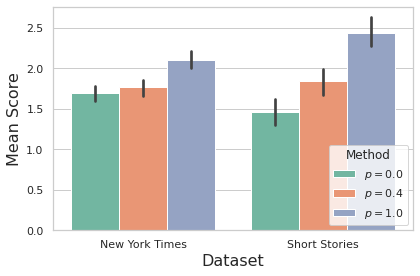

In [36]:
filtered_df = full_df[
                      (full_df["model"]=="gpt2-xl") & 
                      (full_df["dataset"]=="Short Stories") | (full_df["dataset"]=="New York Times") &
                      (full_df["dec_strat_value"] != -1)]

filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)
p = sns.barplot(x="dataset", y="points", hue="dec_strat_value", data=filtered_df)
# p.set_title("Comparison of Generation Performance of GPT2-XL across values of top-p")
p.set_xlabel("Dataset", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)
p.legend(loc="lower right").set_title("Method")
plt.tight_layout()
plt.savefig("topp.pdf")

### Comparison of GPT2-XL p=0.4 across reddit, nyt, and recipes

**Conclusion:** We see that Recipes are the most difficult, then NYT and short stories. This shows that generation systems struggle with structured text and are better at more open-ended generations (?). Also shows that domain knowledge is important. (although NYT being better than reddit is interesting).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


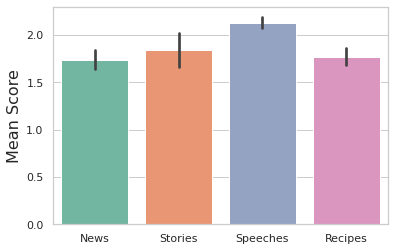

In [37]:
filtered_df = full_df[((full_df["model"]=="gpt2-xl") | (full_df["model"]=="ctrl-Politics") | (full_df["model"]=="ctrl-nocode")) & 
                                     (full_df["dec_strat_value"]==0.4)]

filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)
filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)

p = sns.barplot(x="dataset", y="points", data=filtered_df, order=["News", "Stories", "Speeches", "Recipes"])
# p.set_title("Comparison of Generation Performance of GPT2-XL across Textual Genre")
p.set_xlabel("")
p.set_ylabel("Mean Score", fontsize = 16)
plt.savefig("genre.pdf")

## Comparison of all-human performance
Comparison of performance on only all-human examples across all 4 datasets

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Mean Score')

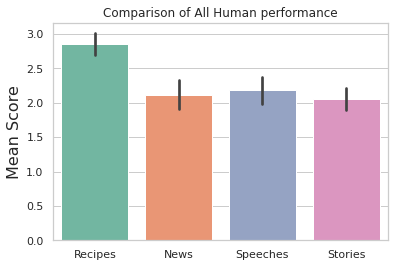

In [38]:
filtered_df = full_df[(full_df["model"]=="human")]

filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)

p = sns.barplot(x="dataset", y="points", data=filtered_df)
p.set_title("Comparison of All Human performance")
p.set_xlabel("")
p.set_ylabel("Mean Score", fontsize = 16)

### Comparison of Model Size across same dataset and p-value

**Conclusion**: Bigger Models are better (good sanity check, nice to know this is confirmed) -- don't use GPT3 here because we only have 89 annotations

Text(0, 0.5, 'Mean Score')

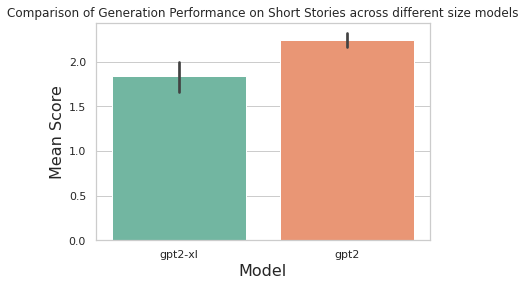

In [39]:
filtered_df = full_df[(full_df["dataset"]=="Short Stories") & 
                                     (full_df["dec_strat_value"]==0.4) & 
                                     (full_df["model"]!="davinci")]

p = sns.barplot(x="model", y="points", data=filtered_df, order=['gpt2-xl', 'gpt2'])
p.set_title("Comparison of Generation Performance on Short Stories across different size models")
p.set_xlabel("Model", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

### Comparison of fine-tuning performance


Text(0, 0.5, 'Mean Score')

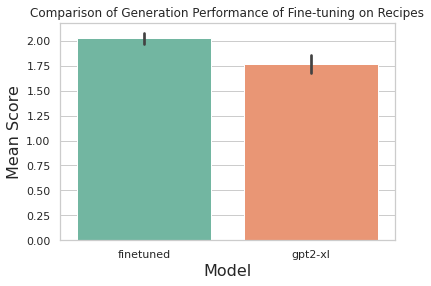

In [40]:
filtered_df = full_df[(full_df["dataset"]=="Recipes")]

p = sns.barplot(x="model", y="points", data=filtered_df, order=['finetuned', 'gpt2-xl'])
p.set_title("Comparison of Generation Performance of Fine-tuning on Recipes")
p.set_xlabel("Model", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

### Comparison of CTRL with and without control code

Text(0, 0.5, 'Mean Score')

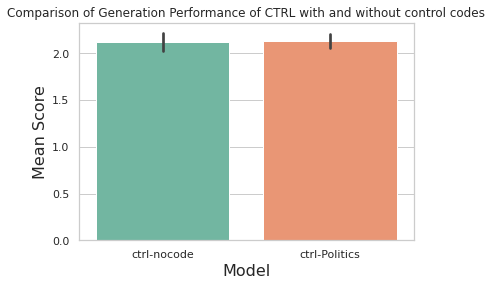

In [41]:
filtered_df = full_df[(full_df["dataset"]=="Presidential Speeches")]

p = sns.barplot(x="model", y="points", data=filtered_df, order=['ctrl-nocode','ctrl-Politics'])
p.set_title("Comparison of Generation Performance of CTRL with and without control codes")
p.set_xlabel("Model", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

###Mean Points for users that have no familiarity with generated text vs. users that do

(-0.6, 5.5)

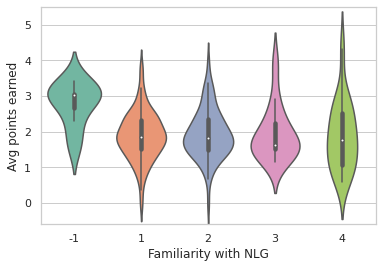

In [42]:
df_familiarity=full_df.groupby(["username", "gen_familiarity"]).points.mean().reset_index()
df_familiarity.rename({"gen_familiarity": "Familiarity with NLG", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Familiarity with NLG", y="Avg points earned", data=df_familiarity)
plt.ylim([-0.6, 5.5])

### Mean Points for native vs. non-native English speakers

(-0.6, 5.5)

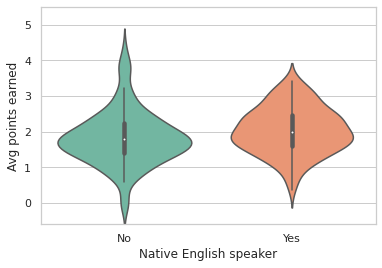

In [43]:
df_language=full_df.groupby(["username", "english"]).points.mean().reset_index()
df_language.rename({"english": "Native English speaker", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Native English speaker", y="Avg points earned", data=df_language)
plt.ylim([-0.6, 5.5])

##Mean points for users with familiarity in a given domain
TODO

## Point Distributions

### Per playlist

In [44]:
import collections

In [45]:
df = full_df[full_df["model"].isin(('ctrl-Politics', 'ctrl-nocode', 'finetuned', 'gpt2-xl'))]
df = df[df["dec_strat_value"] == 0.4]

playlists = set(df["dataset"].tolist())
to_plot = []
for playlist in playlists:
  points = df[df["dataset"]==playlist].points.tolist()
  points = collections.Counter(points)

  heights = np.array(list(points.values())) / sum(points.values())
  for point_value, height in zip(points, heights):
    to_plot.append({"Points earned": point_value,
                    "Fraction of annotations":height,
                    "Domain": map_playlist_name(playlist)})

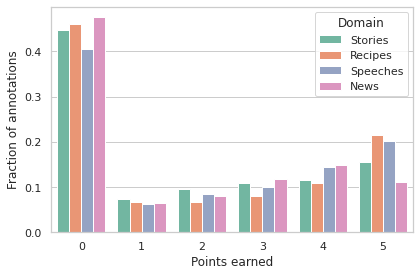

In [46]:
to_plot = pd.DataFrame(to_plot)
sns.barplot(x="Points earned", y="Fraction of annotations", hue="Domain", data=to_plot)
save("point_distribution.pdf")

### Per annotator

<AxesSubplot:title={'center':'Achieved Points Distribution'}, ylabel='Frequency'>

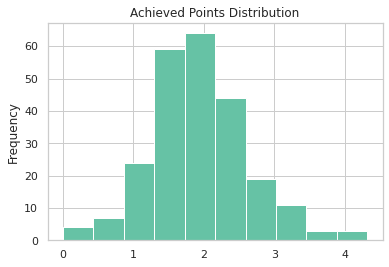

In [47]:
full_df.groupby('annotator').points.mean().plot.hist(
    title='Achieved Points Distribution'
)

## Find bad annotators

In [48]:
full_df["predicted_boundary_index"]
full_df.groupby('annotator').sum()

,generation,predicted_boundary_index,points,prompt,true_boundary_index,prompt_index,dec_strat_value,recipe_familiarity,news_familiarity,stories_familiarity,gen_familiarity
annotator,,,,,,,,,,,
1661,605198,135,52,441774,176,15390,13.6,136,102,68,34
1666,411682,72,29,290125,96,135211,6.8,34,51,85,34
1682,73939,5,6,49634,13,9080,2.0,10,25,20,5
1699,1499001,558,128,1120672,412,353521,34.0,348,348,348,174
1700,122628,50,28,85711,67,26670,5.0,60,45,30,30
...,...,...,...,...,...,...,...,...,...,...,...
5505,1769454,514,267,1277786,516,371516,44.2,214,321,428,107
5506,776988,228,85,555203,199,74008,16.8,138,230,92,46
5540,4217419,2148,407,2941117,1229,583588,109.0,270,540,270,270


In [49]:
def find_problematic_annotators(df):
  """Analyze whether annotators improve in aggregate over k annotations."""
  
  too_many_same_df = []

  for annotator in set(df["annotator"].tolist()):
    guesses = df[df["annotator"] == annotator]["predicted_boundary_index"].tolist()
    
    # Check of they almost always guessed the same boundary
    modal_guess = scipy.stats.mode(guesses)
    fraction_modal = modal_guess.count[0] / len(guesses)
    if fraction_modal > 0.9:
      too_many_same_df.append((annotator, modal_guess, fraction_modal, len(guesses)))

  return pd.DataFrame(
      too_many_same_df, columns=["annotator", "guess", "fractional_model", "num_annotations"])
df = find_problematic_annotators(full_df)
df

,annotator,guess,fractional_model,num_annotations
0,2707,"([0], [1])",1.0,1


Text(0, 0.5, 'Chosen boundary')

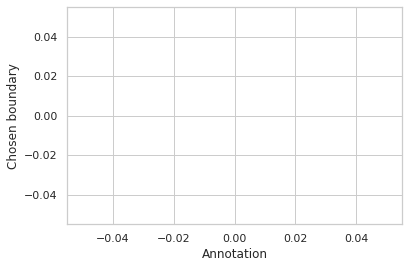

In [50]:
ys = full_df[full_df["annotator"] == 4415].sort_values("date")["predicted_boundary_index"].tolist()
plt.scatter(x=range(len(ys)), y=ys)
plt.xlabel("Annotation")
plt.ylabel("Chosen boundary")

## Annotator performance over time

Of the annotators who did at least K annotations, plot their mean score over time

In [51]:
def analyze_progress(df, k=50):
  """Analyze whether annotators improve in aggregate over k annotations."""
  all_score_series = []
  annotators = df[df["pk"] > k].reset_index()["annotator"].tolist()
  for annotator in annotators:
    annotations = annotation_df[annotation_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["points"][:k].tolist()
    all_score_series.append(score_series)

  return np.array(all_score_series), len(annotators)

In [52]:
def analyze_and_plot(s, n, k):
  print(n)
  data = np.array(s)
  data = np.mean(data, axis=0)
  print("spearmanr: %.2f, %f" % stats.spearmanr(range(k), data))
  print("pearsonr: %.2f, %f" % stats.pearsonr(range(k), data))
  plt.plot(range(1, k+1), data)
  plt.ylabel("Mean score")
  plt.xlabel("$n$th annotation")
  plt.title("Performance over time")
  plt.show()

### Analysis of annotators getting better over time (1st Batch)

**Conclusion**: We see no correlation on the first batch of annotators. They do not improve over time

21
spearmanr: -0.19, 0.191915
pearsonr: -0.13, 0.363885


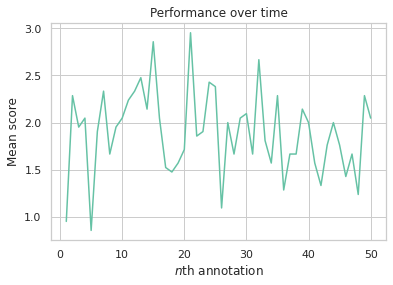

In [53]:
k = 50
s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

12
spearmanr: 0.02, 0.878400
pearsonr: 0.01, 0.928760


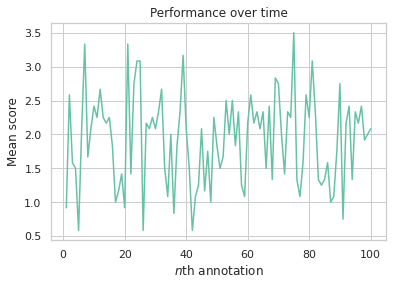

In [54]:
k = 100
s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

3
spearmanr: -0.02, 0.765984
pearsonr: -0.02, 0.784570


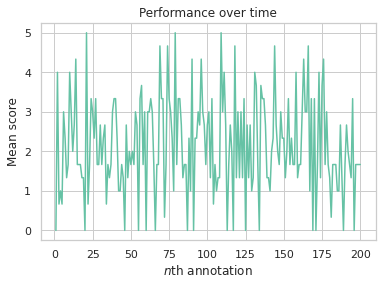

In [55]:
k = 200
s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

### Analysis of annotators getting better over time (2nd Batch)

**Conclusion**: We actually see a positive correlation (over 0.3) for k=50, 100, and 200 on the second batch of annotators. They DO actually improve over time. This suggests that, with the correct instructions, annotators may be able to be taught how to improve at detecting generated text.

89
spearmanr: 0.43, 0.001784
pearsonr: 0.36, 0.009909


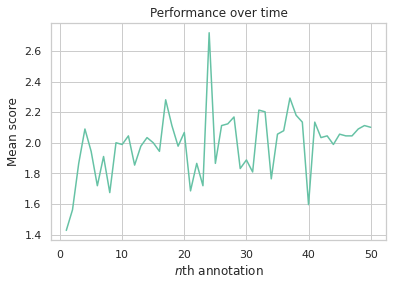

In [56]:
k = 50
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

84
spearmanr: 0.59, 0.000000
pearsonr: 0.59, 0.000000


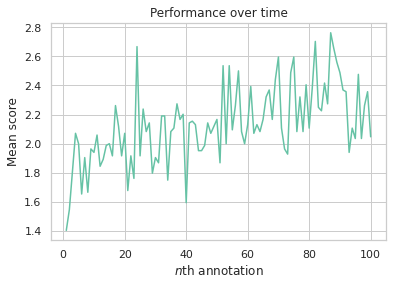

In [57]:
k = 100
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

41
spearmanr: 0.23, 0.001073
pearsonr: 0.20, 0.003738


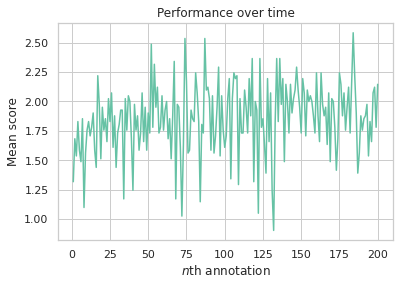

In [58]:
k = 200
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

## Inter-annotator agreement

### Difference in abilities

In [59]:
def analyze_ability_differences(df, k=50):
  """Analyze whether annotators improve in aggregate over k annotations."""
  df = df.groupby('annotator').count()
  all_score_series = []
  annotators = df[df["pk"] >= k].reset_index()["annotator"].tolist()
  for annotator in annotators:
    annotations = annotation_df[annotation_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["points"][:k].tolist()
    all_score_series.append(score_series)
    
  return all_score_series

In [60]:
scores = analyze_ability_differences(full_df, 50)
sum_scores = [sum(s) for s in scores]

In [61]:
print("Mean score:", np.mean(sum_scores))
print("Std score:", np.std(sum_scores))

Mean score: 98.51818181818182
Std score: 26.85101380113533


In [62]:
df = full_df.groupby('annotator').count()
annotators = df[df["pk"] >= 50].reset_index()["annotator"].tolist()

df = full_df[full_df["annotator"].isin(annotators)]
df = df.groupby('annotator').sum()
# df = annotation_df.groupby('generation').boundary.apply(list).reset_index()
# df = df[df.apply(lambda row: len(row["boundary"]) >= 4, axis=1)]

### Fraction agreement
For every pair of annotators who annotated the same generaton, what fraction guessed the same boundary?

In [63]:
annotations_per_gen = annotation_df.groupby('generation')
num_annotations_per_gen = annotations_per_gen.points.count()

In [64]:
def analyze_fraction_agreements():
  generation_ids = set(full_df["generation"].tolist())
  annotations_per_gen = full_df.groupby('generation')

  overall_num_annotations = 0
  overall_num_agreements = 0

  x = annotations_per_gen.predicted_boundary_index.value_counts()
  for idx, generation in enumerate(generation_ids):
    chosen_boundaries = x[generation]
    chosen_boundaries = {k: chosen_boundaries[k] for k in chosen_boundaries.keys()}
    
    total_annotations = sum(chosen_boundaries.values())
    if total_annotations > 1:
      total_agreements = sum(v for v in chosen_boundaries.values() if v > 1)

      overall_num_annotations += total_annotations
      overall_num_agreements += total_agreements

  print("Out of {} total annotations on generations with >1 annotation, {} were in agreement with another annotation on the true boundary position. That is {}".format(
      overall_num_annotations, overall_num_agreements, overall_num_agreements/overall_num_annotations
  ))
analyze_fraction_agreements()

# TODO: Figure out what the baseline of random guessing would be,

Out of 23066 total annotations on generations with >1 annotation, 11259 were in agreement with another annotation on the true boundary position. That is 0.48812104396080813


### Krippendorf's Alpha

In [65]:
import nltk.metrics

In [66]:
from nltk.metrics.agreement import AnnotationTask

In [67]:
df = full_df.groupby('generation').predicted_boundary_index.apply(list).reset_index()
df = df[df.apply(lambda row: len(row["predicted_boundary_index"]) >= 4, axis=1)]

In [68]:
annotation_data = []
for idx, row in full_df.iterrows():
  coder = row["annotator"]
  item = row["generation"]
  label = row["predicted_boundary_index"]
  annotation_data.append((coder,item,label))

In [69]:
ann_task = AnnotationTask(annotation_data)

In [70]:
print(ann_task.alpha())

-0.5381196662250638


## Profile Statistics

In [71]:
def user_stats(df, name):
  data = {"name": name}
  data["num_participants"] = len(np.unique(df["annotator"]).tolist())
  data["num_annotations"] = len(df)
  data["mean_annotations_per_participant"] = data["num_annotations"] / data["num_participants"] 
  data["mean_points"] = np.mean(df["points"])
  data["std_points"] = np.std(df["points"])
  return data

In [72]:
all_data = []
all_data.append(user_stats(full_df, "overall"))
all_data.append(user_stats(full_df[(full_df['date'] <= '2021-10-1')], "Section A"))
all_data.append(user_stats(full_df[(full_df['date'] > '2021-10-1')], "Section B"))

In [73]:
pd.DataFrame(all_data)

,name,num_participants,num_annotations,mean_annotations_per_participant,mean_points,std_points
0,overall,238,24188,101.630252,2.043162,2.109427
1,Section A,141,6658,47.219858,1.975819,2.126416
2,Section B,99,17530,177.070707,2.068739,2.102374


# Time Tracking Analysis
TODO: double check that timestamps are properly merged with the correct annotations. Also find a better way to calculate time delta than shift down by 1 and filter.

In [74]:
timing_df = get_df('core.timestamp')
timing_df = timing_df.rename(columns={'date': 'timestamp'}).merge(full_df, left_on='annotation', right_on='pk')

In [75]:
timing_df['timestamp'] = pd.to_datetime(timing_df.timestamp)
timing_df['delta'] = timing_df.timestamp - timing_df.timestamp.shift(1)
timing_df['delta'] = timing_df.delta.dt.components.milliseconds / 1000.0 + timing_df.delta.dt.components.seconds + timing_df.delta.dt.components.minutes * 60.0
timing_df = timing_df[timing_df.delta < 120] # TODO: Do this more properly instead of shift and filter

## Median Time Delta

In [76]:
timing_df.delta.median()

2.305

## Correlation Between Time Delta and Decoding Hyperparameter (top-p)

In [77]:
timing_df[['dec_strat_value', 'delta']].corr()

,dec_strat_value,delta
dec_strat_value,1.000000,-0.003306
delta,-0.003306,1.000000


## Time Delta Distribution

<AxesSubplot:>

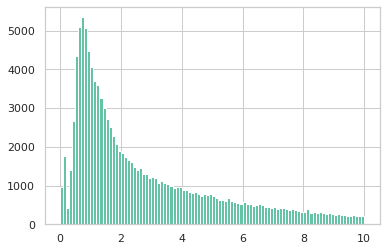

In [78]:
timing_df.delta.hist(bins=100, range=(0,10))
#plot( kind='hist',    range=(0, 60),    bins=30,    figsize=(20, 10),    title=('Turn Duration Distribution (seconds)')  )

## Correlation Between Time Delta and Sentence Length

In [79]:
timing_df['gen_body_length'] = timing_df.gen_body.str.len()
timing_df.groupby('annotation').agg({'delta': 'sum', 'gen_body_length': 'mean'}).corr()

,delta,gen_body_length
delta,1.000000,-0.093731
gen_body_length,-0.093731,1.000000


## Correlation Between Time Delta and Points

In [80]:
timing_df.groupby('annotation').agg({'delta': 'sum', 'points': 'mean'}).corr()

,delta,points
delta,1.000000,0.140925
points,0.140925,1.000000


## Comparison of Average Time Deltas Between Text Domains

<AxesSubplot:xlabel='dataset'>

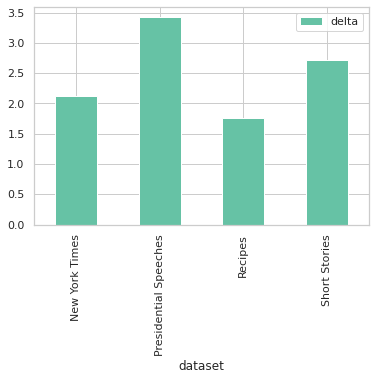

In [81]:
# Median
timing_df.groupby('dataset').agg({'delta': 'median'}).plot.bar()

<AxesSubplot:xlabel='dataset'>

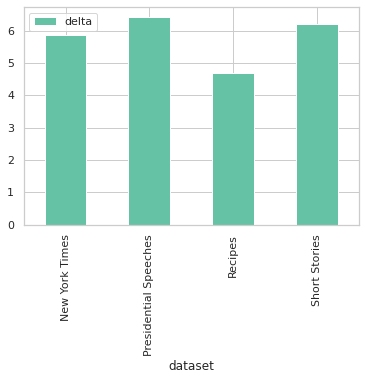

In [82]:
# Mean
timing_df.groupby('dataset').agg({'delta': 'mean'}).plot.bar()

## Comparison of Average Time Deltas Between Models

<AxesSubplot:xlabel='model'>

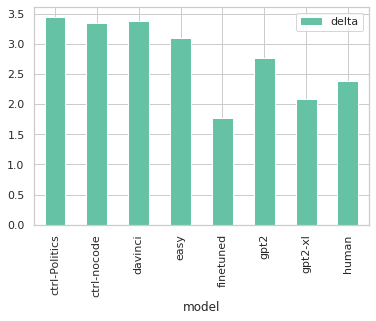

In [83]:
# Median
timing_df.groupby('model').agg({'delta': 'median'}).plot.bar()

<AxesSubplot:xlabel='model'>

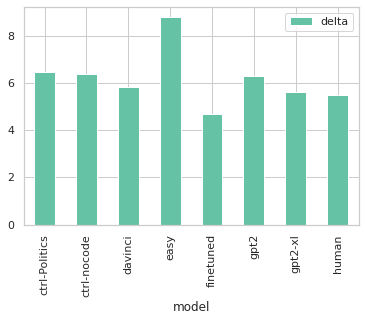

In [84]:
# Mean
timing_df.groupby('model').agg({'delta': 'mean'}).plot.bar()